# **Импорт всех пакетов**

In [1]:
import tensorflow as tf
import keras
from keras import layers, regularizers, optimizers
from keras.layers import (
    Dense,
    Add,
    Flatten,
    Input,
    Activation,
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dropout,
    Lambda,
    concatenate,
)
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import cv2
import numpy as np
from numpy import load, save
import re
import keras.backend as K

import json
from tqdm.notebook import trange, tqdm

K.set_image_data_format("channels_last")
K.set_learning_phase(1)

WIDTH = 128  # Размер изображения 128

/home/voland/.local/lib/python3.6/site-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


# **Предварительная обработка изображения и данных**

In [2]:
# ! pip install pyarrow==6.0.1


In [32]:
# Reading train.parquet file using pandas
train = pd.read_parquet("train.parquet", engine="pyarrow")
test = pd.read_parquet("test.parquet", engine="pyarrow")

In [4]:
train.head(1)

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...


In [5]:
test.head(1)

,product_id,sale,shop_id,shop_title,rating,text_fields
1,1997646,False,22758,Sky_Electronics,5.0,"{""title"": ""Светодиодная лента Smart led Strip ..."


Разделим категории на подкатегории и посмотрим сколько уникальных категорий содержит наш набор

In [6]:
query_train = train.category_name.str.split("->", 5, expand=True)

In [7]:
query_train.head(2)


,0,1,2,3,4,5
0,Все категории,Электроника,Смартфоны и телефоны,Аксессуары и запчасти,Зарядные устройства и кабели,Кабели
1,Все категории,Одежда,Женская одежда,Белье и купальники,Трусы,None


In [8]:
for i in range(5):
    print(
        i,
        "Have None in %d values? --> %s"
        % (query_train[i].nunique(), (None in query_train[i].unique())),
    )


0 Have None in 1 values? --> False
1 Have None in 5 values? --> False
2 Have None in 45 values? --> False
3 Have None in 278 values? --> True
4 Have None in 532 values? --> True


2 колонка разбивается на категории без Нан значений. 
Таким образом мы будем использовать 45 уникальных категорий

In [9]:
train["category_name"] = query_train[2]

Прописываем название изображения в колонке product_id в формате 1.jpg

In [10]:
train["product_id"] = train["product_id"].apply(lambda x: str(x) + ".jpg")

In [11]:
# НЕ ПОДОШЛО - перевод колонки в JSON и нормализация по столбцу выдает неверные значения (Оставлено для истории)

# Колонка text_fields содержит значения. Поэтому разбиваем их в датафрейм
# df_json1 = pd.json_normalize(train["text_fields"].apply(json.loads).apply(lambda x: x['title']))
# Чтобы заменить все невложенные HTML теги на пробелы в столбце description
# df_json1["description"] = df_json1["description"].str.replace(r"\<[^\>]*\>", " ")
# Объединяем df
# train = train.join(df_json1)
# Давайте посмотрим на перетасованные данные, которые будут использоваться для предварительной обработки данных.
# удалены все столбцы, в которых количество не-NaN элементов меньше 50.
# train = train.dropna(axis=1, thresh=50)
# НИЖНИЙ РЕЗУЛЬТАТ БЫЛ НЕ ВЕРЕН
# train.query("product_id == '201.jpg'")


In [12]:
col_tf = train["text_fields"].apply(
    json.loads)[0].keys()

In [13]:
col_tf

dict_keys(['title', 'description', 'attributes', 'custom_characteristics', 'defined_characteristics', 'filters'])

In [14]:
# Колонка text_fields содержит значения в json формате.  Необходимая колонка это 'title'
for col in col_tf:
    train[col] = train["text_fields"].apply(
    json.loads).apply(lambda x: x[col])


***Вывод***: важные столбцы
- Первый столбец - это названия изображений продуктов 'product_id', которые мы будет использовать для чтения изображений, 
- 2-й - категория продукта 'category name', а 
- последний столбец - это название продукта 'title'. 

In [15]:
train = train.drop(columns=['text_fields'],axis = 1)

In [16]:
train.head(1)

,product_id,category_id,sale,shop_id,shop_title,rating,category_name,title,description,attributes,custom_characteristics,defined_characteristics,filters
0,325286.jpg,12171,False,9031,Aksik,5.0,Смартфоны и телефоны,Зарядный кабель Borofone BX1 Lightning для айф...,"<p><span style=""background-color: transparent;...","[Длина: 1м, Разъем: Lightning, Подерживает быс...",{},"{'Цвет': ['Черный', 'Белый']}","{'Цвет': ['Белый', 'Черный']}"


In [15]:
# Случайно перетасовать данные
# train = shuffle(train)
# train = train.reset_index(drop=True)


In [16]:
# import os
# from PIL import Image

# # https://github.com/python-pillow/Pillow/issues/4574
# # Сохраним сжатые картинки в лучшем качестве в папке images/train_PIL
# # Расположение извлеченных изображений
# path = "images/train"
# train_images = []  # Создание пустого списка для сохранения изображений
# path_output = "images/train_PIL"

# for img in tqdm(
#     train["product_id"]
# ):  # Итерация над всеми именами изображений в train ['product_id'] для чтения изображений
#     final_path = os.path.join(
#         path, img
#     )  # Присоединение пути с изображениями, чтобы получить полный путь изображений
#     final_path2 = os.path.join(
#         path_output, img
#     )
#     # Чтение изображений с использованием PILLOW
#     img = Image.open(final_path)

#     img.resize((WIDTH, WIDTH), Image.ANTIALIAS)  # Width: 64, Height: 64
#     img.save(final_path2, quality=100)
# im = Image.open("images/train/120.jpg")
# im.size

In [20]:
import os
from PIL import Image

# Расположение извлеченных изображений
path = "images/train"
train_images = []  # Создание пустого списка для сохранения изображений


def create_train():  # Определение функции для создания обучающих данных по изображениям.
    # Итерация над всеми именами изображений в train ['product_id'] для чтения изображений
    for img in tqdm(train["product_id"]):
        # Присоединение пути с изображениями, чтобы получить полный путь изображений
        final_path = os.path.join(path, img)

        # Чтение изображений с использованием PILLOW
        # img = Image.open(final_path)

        # pil_image = img.convert('RGB')
        # pil_image = np.array(pil_image) / 255 # Normalize data
        # # Convert RGB to BGR
        # img_arr = open_cv_image[:, :, ::-1].copy()
        train_img = cv2.imread(final_path)  ## reading images using cv2

        # Чтение изображений с использованием CV2 BAD QUALITY
        # train_img = cv2.imread(final_path)
        # #Мы изменим размер наших изображений, чтобы стать изображениями (WIDTH,WIDTH). Интерполяцию выбираем INTER_AREA, дольше но четче изображения
        # Сохранение измененного изображения в списке Train_images.Этот процесс повторился, пока мы не достигнем последнего имени изображения.
        img_arr = cv2.resize(
            train_img,
            (WIDTH, WIDTH),
            interpolation=cv2.INTER_AREA,
        )

        train_images.append(img_arr)


create_train()  # Теперь вызов нашей функции создания, чтобы получить список

  0%|          | 0/91120 [00:00<?, ?it/s]

KeyboardInterrupt: 

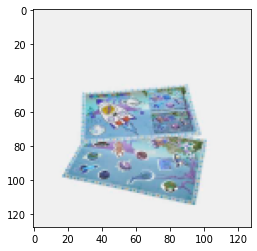

In [18]:
plt.imshow(train_images[10])


In [19]:
train.category_name.nunique()

45

У нас не нан 45 уникальных категорий товара

In [20]:
# Создание численных меток category_name в наших данных
train["category_name"] = train["category_name"].astype("category")
train["uniq_labels"] = train["category_name"].cat.codes

У нас сейчас есть численные labels для работы

/home/voland/anaconda3/envs/rtx_3060/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='labels', ylabel='count'>

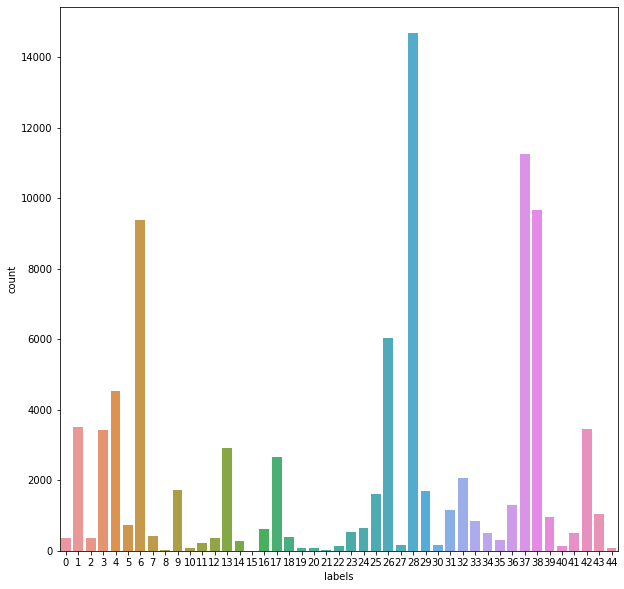

In [21]:
# Let's have a look at the label distribution
plt.figure(figsize=(10, 10))
sns.countplot(train["uniq_labels"])

Как вы можете видеть, на labels 28 произошло больше всего количества раз, что составляет около 14000. Есть много labels, которые происходят менее чем в 1000 раз.Есть 12 labels, которые происходили более 2000 раз. 

Надо решить задачу многоклассовой классификации. В качестве метрики для задания выбран взвешенный F1-score

In [24]:
train["category_id"].nunique()

874

In [17]:
# Теперь давайте создадим множество тренировочных лейблов.
train_labels = train["category_id"]
train = train.drop(columns=['category_id'],axis = 1)
train_labels = np.array(train_labels)

In [18]:
train_labels.shape


(91120,)

In [19]:
# Изменить Training_label для получения соответствующего формата
train_labels = train_labels.reshape(train_labels.shape[0], -1)


In [20]:
train_labels.shape


(91120, 1)

In [23]:
np.unique(train_labels)

91120

У нас 874 labels. Следовательно, нам нужно one-hot encoding, чтобы сделать классификацию

In [27]:
# np.eye() Создаст матрицу идентификации, которая будет использовать учебные labels в качестве индекса для
# one-hot представление.Например, если каждый раз labels 0 появляется первым столбцом, будет одним еще ноль.Ограничительно для других классов.
train_labels = np.eye(874)[train_labels.reshape(-1)]

In [28]:
train_labels.shape


(91120, 45)

Now we have one hot encoding of labels 

In [29]:
train_labels


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Мы сохранили изображения в списке.Но для запуска алгоритмов поверх наших данных нам нужен массив формы, подобной (нет, высота, ширина, каналы).Там, где никто не является чем -то иным, как представлением количества изображений, высота и ширина - это размер изображения (пиксели), а каналы используются для представления изображений Graysacale или RGB.Если это изображение серого, то это будет 1, если изображение будет RGB, то канал будет 3. Таким образом, мы преобразуем наши данные изображения в этом формате.

In [30]:
len(train_images)

91120

In [31]:
# Преобразование наших данных train_images из списка в массив
# Наши данные занимают много места в Оперативной памяти поэтом используем np.memmap
# https://stackoverflow.com/questions/16149803/working-with-big-data-in-python-and-numpy-not-enough-ram-how-to-save-partial-r
# https://stackoverflow.com/questions/67736180/numpy-memory-error-converting-a-big-dataset-from-list-to-numpy-array
# train_images = np.array(train_images)

In [32]:
train_images_memmap = np.memmap(
    "train_images.mymemmap", dtype="float32", mode="w+", shape=(91120, WIDTH, WIDTH, 3)
)


In [33]:
train_images_memmap[:] = train_images[:]  # 2 min wait


Нормализация данных путем деления 255. Причина деления 255 заключается в том, что значение пикселя колеблется от 0 до 255. Это даст нам значения от 0 до 1.

In [34]:
train_images_memmap = train_images_memmap / 255

In [35]:
del train_images

In [36]:
train_images_memmap[1]

array([[[0.8862745 , 0.90588236, 0.9019608 ],
        [0.8862745 , 0.90588236, 0.9019608 ],
        [0.8862745 , 0.90588236, 0.9019608 ],
        ...,
        [0.89411765, 0.9137255 , 0.9098039 ],
        [0.89411765, 0.9137255 , 0.9098039 ],
        [0.89411765, 0.9137255 , 0.9098039 ]],

       [[0.8862745 , 0.90588236, 0.9019608 ],
        [0.8862745 , 0.90588236, 0.9019608 ],
        [0.8862745 , 0.90588236, 0.9019608 ],
        ...,
        [0.89411765, 0.9137255 , 0.9098039 ],
        [0.89411765, 0.9137255 , 0.9098039 ],
        [0.89411765, 0.9137255 , 0.9098039 ]],

       [[0.8862745 , 0.90588236, 0.9019608 ],
        [0.8862745 , 0.90588236, 0.9019608 ],
        [0.8862745 , 0.90588236, 0.9019608 ],
        ...,
        [0.89411765, 0.9137255 , 0.9098039 ],
        [0.89411765, 0.9137255 , 0.9098039 ],
        [0.89411765, 0.9137255 , 0.9098039 ]],

       ...,

       [[0.89411765, 0.9137255 , 0.9098039 ],
        [0.89411765, 0.9137255 , 0.9098039 ],
        [0.89411765, 0

In [37]:
train_images_memmap.shape


(91120, 128, 128, 3)

Теперь у нас есть подходящий формат данных изображения для запуска алгоритмов.На следующем шаге мы разделим наши данные на обучение и тестирование

In [38]:
X_train = train_images_memmap[0:80000, :, :, :]
Y_train = train_labels[0:80000, :]
X_test = train_images_memmap[80000:, :]
Y_test = train_labels[80000:, :]

In [39]:
X_train.shape


(80000, 128, 128, 3)

In [40]:
Y_train.shape


(80000, 45)

In [41]:
train.head(5)


,product_id,title,category_name,labels
0,325286.jpg,Зарядный кабель Borofone BX1 Lightning для айф...,Смартфоны и телефоны,28
1,888134.jpg,Трусы Sela,Женская одежда,6
3,1267173.jpg,"Гуашь ""ЮНЫЙ ВОЛШЕБНИК"", 12 цветов по 35 мл, БО...",Рисование,25
4,1416943.jpg,Колба для кальяна Крафт (разные цвета),Товары для курения,36
5,1058275.jpg,"Пижама женская, однотонная с шортами",Женская одежда,6


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Женская одежда
Трусы Sela


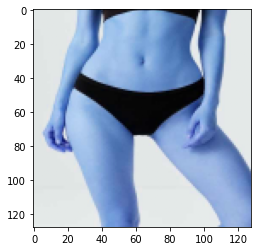

In [42]:
# Давайте посмотрим на одно изображение
n_image = 1
plt.imshow(train_images_memmap[n_image])
print(train_labels[n_image])
print(train["category_name"].iloc[n_image])
print(train["title"].iloc[n_image])


Нормализация данных путем деления 255. Причина деления 255 заключается в том, что значение пикселя колеблется от 0 до 255. Это даст нам значения от 0 до 1.

In [43]:
X_train

array([[[[0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         ...,
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ]],

        [[0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         ...,
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ]],

        [[0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         ...,
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ]],

        ...,

        [[0.9411765 , 0.9411765 , 0.9411765 ],
         [0.9411765 , 0.9411765 , 0.9411765 ]

In [44]:
# Normalizing нужно в массиве с меньшим количеством элементов, так как забивается пасять
# X_train = X_train / 255  # Normalizing train data
# X_test = X_test / 255  # Normalizing test data

Сохранение данных изображения Preprocessesd для будущего использования

In [45]:
# Сохранение данных для будущего использования
save("train.npy", X_train)
save("test.npy", X_test)
save("label_train.npy", Y_train)
save("label_test.npy", Y_test)
del train_images_memmap
del X_test
del X_train
del Y_train
del Y_test


Вы можете загрузить свои данные с помощью кода ниже.

In [2]:
X_train = np.memmap(
    "X_train.mymemmap", dtype="float32", mode="w+", shape=(80000, WIDTH, WIDTH, 3)
)
X_train = load("train.npy")
X_test = load("test.npy")
Y_train = load("label_train.npy")
Y_test = load("label_test.npy")


In [4]:
X_train.max()


1.0

In [5]:
len(X_train[1])


128

24


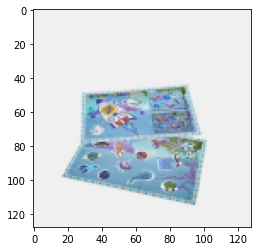

In [6]:
plt.imshow(X_train[10])
print(np.argmax(Y_train[10]))

# **Text PreProcessing**

Мы определим чистую функцию, которая удалит знаки препинания, числа и дополнительные места с конца предложения.Он также заменит буквы верхнего регистра в нижний

In [26]:
train.head(1)

,product_id,category_id,sale,shop_id,shop_title,rating,category_name,title,description,attributes,custom_characteristics,defined_characteristics,filters
0,325286.jpg,12171,False,9031,Aksik,5.0,Смартфоны и телефоны,Зарядный кабель Borofone BX1 Lightning для айф...,"<p><span style=""background-color: transparent;...","[Длина: 1м, Разъем: Lightning, Подерживает быс...",{},"{'Цвет': ['Черный', 'Белый']}","{'Цвет': ['Белый', 'Черный']}"


In [32]:
col_cat = list(['shop_title','rating', 'category_name', 'title', 'description', 'attributes', 'custom_characteristics','defined_characteristics','filter'])

TypeError: list() takes at most 1 argument (9 given)

In [ ]:
def clean_text(data):
    # На этом этапе мы преобразуем Charecters в нижний чехол
    for i in range(data.shape[0]):
        data[i] = data[i].lower()
    # На этом этапе мы удаляем числа и знаки препинания из текста
    for i in range(data.shape[0]):
        data[i] = re.sub(r"[^\w\s]+|[\d]+", "", data[i])
        #  выбрасывает все слова (преимущественно предлоги), длинна которых меньше 3-х символов.
        data[i] = " ".join(word for word in data[i].split() if len(word) > 3)
    # Здесь мы снимаем дополнительное пространство с конца и начала предложения
    for i in range(data.shape[0]):
        data[i] = data[i].strip()
    return data


 **Сравните данные перед чисткой и после очистки жирного шрифта**
 
 **Перед чисткой :** 
'Холсты грунтованные на деревяном подрамнике'

 **После уборки :**  
'холсты грунтованные деревяном подрамнике'

Вы можете видеть, что мы изменили заглавные буквы и удалили числа, знаки препинания и дополнительные места с конца предложения.

In [9]:
MAX_NB_WORDS = 5000
# Максимальное количество слов в каждом имени.
MAX_SEQUENCE_LENGTH = 15
EMBEDDING_DIM = 100

In [29]:
for col in col_cat:
    names = np.array(train[col].astype(str))
    # Применение функции clean_text для получения чистых текстовых данных
    names = clean_text(names)
    # Максимальное количество слов, которые будут использоваться.
    MAX_NB_WORDS = 5000
    # Максимальное количество слов в каждом имени.
    MAX_SEQUENCE_LENGTH = 15
    EMBEDDING_DIM = 100
    
    # Создание токенов слова
    tokenizer = Tokenizer(
        num_words=MAX_NB_WORDS,
        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
        lower=True,
        char_level=False,
    )
    tokenizer.fit_on_texts(names)
    word_index = tokenizer.word_index
    
    print("Found %s unique tokens." % len(word_index))
    # Наконец мы создаем наши текстовые данные для обучения
    X = tokenizer.texts_to_sequences(
        names
    )  # Здесь он берет каждое слово от имен и заменяет его соответствующим номером от нашего Word_index
    X = pad_sequences(
        X, maxlen=MAX_SEQUENCE_LENGTH
    )  # Он преобразует список последовательностей в массив формы Numpy (num_sequence, num_timestep)
    # Где числовая последовательность - это количество предложений в именах, а num_timestep - это количество слов в каждом предложении, которое в данном случае составляет 15.
    print("Shape of data tensor:", X.shape)

NameError: name 'col_cat' is not defined

У нас есть 356090 уникальных токенов, которые мы будем использовать для обучения нашей текстовой модели.

In [ ]:
# Let's look at the tokens
word_index


Shape of data tensor: (91120, 15)


In [ ]:
# Здесь вы можете увидеть массив, где для каждого примера (предложение) у нас есть 15 функций (слова).
X


In [ ]:
# Теперь давайте создадим наборы данных поезда и тестирование
X_traintext = X[0:80000, :]
X_testtext = X[80000:, :]
print(X_traintext.shape, Y_train.shape)
print(X_testtext.shape, Y_test.shape)

Сохранение текстовых данных Preprocessesd для будущего использования

In [ ]:
save("train_text.npy", X_traintext)
save("test_text.npy", X_testtext)


Мы можем перезагрузить текстовые данные с помощью кода ниже

In [3]:
X_traintext = load("train_text.npy")
X_testtext = load("test_text.npy")

# **Image Embeddings**




Это часть 1 назначения, где мы будем использовать предварительную модель VGG16 для получения встроенных изображений.

In [5]:
# Загрузка модели VGG16 с формой (ширина, ширина, 3),
new_model = VGG16(weights="imagenet", include_top=False,
                  input_shape=(WIDTH, WIDTH, 3))
# Исключение последнего слоя и использование весов ImageNet.
model = Sequential()  # Создание новой модели, где мы загрузим нашу модель VGG16
for layer in new_model.layers:
    model.add(layer)
for layer in model.layers:  # Установка слоев модели на триан
    layer.trainable = False
# Добавление уплотненного слоя в конце, чтобы получить векторный выход
model.add(Flatten())


In [4]:
model = Sequential() 

In [13]:
# Теперь давайте посмотрим на резюме модели
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       2

Вы можете увидеть сглаженного слоя в конце, который выводит вектор размеров 2048.Эти встроения 2048 года будут переданы в башню изображения позже.Говоря о модели, вы можете видеть, что есть 14 714 688 общих параметров, но обучаемые параметры 0, так как не хотят обучать модель VGG16.

# **Implementinng Image Tower**

In [5]:
# Создание модели Image_tower
# Как определено , мы собираемся использовать 5 скрытый плотный слой с 512 единицами каждый
# Выпадение 0,15 используется между всеми скрытыми слоями.
# L2 -нормализация используется
image_tower = Sequential()
image_tower.add(Dense(512, activation="softmax"))
image_tower.add(Dropout(0.15))
image_tower.add(Dense(512, activation="softmax"))
image_tower.add(Dropout(0.15))
image_tower.add(Dense(512, activation="softmax"))
image_tower.add(Dropout(0.15))
image_tower.add(Dense(512, activation="softmax"))
image_tower.add(Dropout(0.15))
image_tower.add(
    Dense(512, activation="softmax")
)  # Последний слой с D = 512 скрытыми единицами с последующей нормализацией L2.
image_tower.add(Lambda(lambda xz: K.l2_normalize(xz, axis=1)))  # Normalizing

Теперь мы добавим нашу модель Image_tower в модель встраивания изображений

In [6]:
model.add(image_tower)


In [ ]:
model.summary()


Как видите, существует 14 714 688 необработанных параметров из предыдущей модели и 2 099 712 новых параметров из модели Image_tower, которые подлежат обучению.Последний слой 'Sequiential_2' представляет модель Image_tower.

# **Text Embeddings**

Часть 1 текст встраивает.Здесь мы решили обучить небольшую модель для встраивания текста, а не использовать предварительную модель.Эта модель будет тренироваться, и она передаст текстовые встраивания в Text_tower.

In [10]:
# Создание TextModel
textmodel = Sequential()
# Мы начинаем с эффективного встроенного слоя, который карты
# Наши индексы слока в размеры Embedding_dims
textmodel.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
              input_length=X_traintext.shape[1]))
textmodel.add(Dropout(0.2))

# Мы добавляем Convolution1d, которая изучит фильтры
# Группа слов фильтры по размеру filter_length:
textmodel.add(Conv1D(256, 5, padding="valid", activation="relu", strides=1))
# Мы используем Max Pooling:
textmodel.add(GlobalMaxPooling1D())

# Добавляем полностью подключенный скрытый слой:
textmodel.add(Dense(512))
textmodel.add(Dropout(0.2))
textmodel.add(Activation("relu"))


In [19]:
# Теперь посмотрите на краткое изложение этой модели
textmodel.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           500000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 256)           128256    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation (Activation)      (None, 512)              

In [ ]:
X_train

Таким образом, у нас есть 7 слоев в этой модели и 759 840 параметров, которые можно обучить.И последний слой передаст текстовые встроения в текстовую башню.

# **Implementing Text tower**

Теперь мы будем реализовать текстовую башню части 2.Здесь мы приняли ссылки из «4.1.3 Процесс обучения» бумаги на создание текстовой башни.Мы также приняли ссылки из «3.2. Структура сети» третьего абзаца, который является «Текстовой башней и башней изображения может иметь различное количество скрытых слоев и разные скрытые размеры слоев. Единственное ограничение заключается в том, что последний слой обеих башен должен иметь dскрытые единицы с последующей нормализацией L2 "


In [11]:
# Creating text_tower model
# As defined in paper we are going to use 2 hidden Dense layer with 512 units each
# A dropout of 0.15 is used between all hidden layers.
# L2 normalization is used
text_tower = Sequential()
text_tower.add(Dense(512, activation="relu"))
text_tower.add(Dropout(0.15))
text_tower.add(
    Dense(512, activation="relu")
)  # Last layer with D=512 hidden units followed by L2 normalization.
# L2 normalizaton.
text_tower.add(Lambda(lambda xz: K.l2_normalize(xz, axis=1)))

Now we will add text_tower model to text embedding model

In [12]:
# Добавление text_tower в TextModel
textmodel.add(text_tower)


In [ ]:
# Давайте сейчас посмотрим TextModel.
textmodel.summary()


Как видите, в общей сложности 1 285 152 параметров, и все параметры установлены для обучения.Последний слой, который является «sequential_4», представляет модель Text_tower.

# **Final Model**

Now we will merge both the models and add final layer for classification

In [24]:
# merged = concatenate(model.output, textmodel.output)  # Объединение обеих моделей
out = Dense(874)(textmodel.output)  # Добавление плотного слоя в объединенные слои
# Добавление активации Softmax для классификации
out = Activation("softmax")(out)
final_model = Model(
     textmodel.input, out
)  # Окончательная модель, которую мы будем использовать для классификации

In [15]:
# Давайте посмотрим на окончательную модель.
final_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, 15)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 100)           500000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 256)           128256    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0     

Посмотрите на слой «sequential_2».Эти слои объединяются (объединяются) в слой «concatenate_1».В Final_Model мы имеем в общей сложности 18 148 752 параметров, из которых 3,434 064 обучения.14 714 688 параметров не подлежат обучению, которые взяты из модели VGG16.Эта модель будет использоваться далее для классификации.

# **Class Level Similarity**

будем использовать RMSPROP-оптимизацию с помощью Learning_Rate = 1,6192E-5.Мы будем использовать "Categorical_crossentropy"

In [ ]:
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
# https://stackoverflow.com/questions/50139087/nans-with-customised-weighted-f1-score-in-keras
# import keras.backend as K

# def get_f1(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

In [16]:
# https://stackoverflow.com/questions/59963911/how-to-write-a-custom-f1-loss-function-with-weighted-average-for-keras
def get_f1(true, pred):  # shapes (batch, 4)

    # for metrics include these two lines, for loss, don't include them
    # these are meant to round 'pred' to exactly zeros and ones
    # predLabels = K.argmax(pred, axis=-1)
    # pred = K.one_hot(predLabels, 4)

    ground_positives = K.sum(true, axis=0) + K.epsilon()  # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()  # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP
    # all with shape (4,)

    precision = true_positives / pred_positives
    recall = true_positives / ground_positives
    # both = 1 if ground_positives == 0 or pred_positives == 0
    # shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    # still with shape (4,)

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives)
    weighted_f1 = K.sum(weighted_f1)

    return weighted_f1  # for metrics, return only 'weighted_f1'


In [26]:
from tensorflow.keras import (
    optimizers,
)  # переустановить библиотеку так как не находит rmsprob

# При использовании метрик в model.compile в keras сообщите ValueError: («Неизвестная метрическая функция», «: f1score»)
# На компьютере установлена старая библиотека keras

final_model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1.6192e-5),
    # optimizer=optimizers.experimental.Adafactor(learning_rate=1.6192e-5),
    loss="categorical_crossentropy",
    metrics=[get_f1, "accuracy"],
)


In [14]:
# Проверка доступа к видеокарте
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


Num GPUs Available:  1


In [15]:
!nvidia-smi


Tue Mar 21 00:40:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0  On |                  N/A |
|  0%   46C    P2    54W / 170W |  10507MiB / 12288MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We are definining a callback which will stop training after we have achieved the f1_score of 98% or greater on validation set.

In [20]:
X_traintext.shape

(80000, 15)

Finally training our model

In [28]:
final_model.fit(X_traintext, Y_train, batch_size=256,epochs=400,validation_split=0.05)

Epoch 1/400
297/297 [==============================] - 1s 3ms/step - loss: 2.4029 - get_f1: 0.3057 - accuracy: 0.5906 - val_loss: 2.4257 - val_get_f1: 0.3154 - val_accuracy: 0.5987
Epoch 2/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3834 - get_f1: 0.3102 - accuracy: 0.5935 - val_loss: 2.4070 - val_get_f1: 0.3197 - val_accuracy: 0.6003
Epoch 3/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3637 - get_f1: 0.3141 - accuracy: 0.5966 - val_loss: 2.3891 - val_get_f1: 0.3236 - val_accuracy: 0.6003
Epoch 4/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3443 - get_f1: 0.3182 - accuracy: 0.5992 - val_loss: 2.3718 - val_get_f1: 0.3276 - val_accuracy: 0.6037
Epoch 5/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3258 - get_f1: 0.3224 - accuracy: 0.6017 - val_loss: 2.3525 - val_get_f1: 0.3320 - val_accuracy: 0.6075
Epoch 6/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3068 - get_f1: 0.3

Evaluating model on test set

In [29]:
final_model.evaluate(X_testtext, Y_test)

348/348 [==============================] - 1s 1ms/step - loss: 1.0745 - get_f1: 0.7685 - accuracy: 0.7960


[1.0745106935501099, 0.7684622406959534, 0.7960431575775146]

In [30]:
final_model.save("text_model.h5")

In [31]:
final_model.save_weights("text_model_weights.h5")

In [ ]:
# Predicting on X_test and X_testtext datasets
pred = inter_output_model.predict(X_testtext)

In [47]:
test

,product_id,sale,shop_id,shop_title,rating,text_fields,title,description,attributes,custom_characteristics,defined_characteristics,filters
1,1997646,False,22758,Sky_Electronics,5.000000,"{""title"": ""Светодиодная лента Smart led Strip ...","Светодиодная лента Smart led Strip Light, с пу...","<p>Светодиодная лента LED, 5 м, RGB (Цветная) ...","[Легкость управления с пульта, а так же смартф...",{},{},"{'Тип питания': ['От сети', 'От USB'], 'В комп..."
2,927375,False,17729,Di-Di Market,4.405941,"{""title"": ""Стекло ПЛЕНКА керамик матовое Honor...",Стекло ПЛЕНКА керамик матовое Honor 50 lite 10...,"<p><span style=""color: rgb(63, 62, 62);"">Защит...",[Honor 50 ПЛЕНКА!!! КРАЯ КЛЕЮТСЯ МОГУТ НЕ ПРО...,"{'Модель': ['8a - Y6 2019', '9x - P Smart Z', ...",{},"{'Модель устройства': ['Honor 9X', 'Honor 20 P..."
3,1921513,False,54327,VisionStore,4.000000,"{""title"": ""Проводные наушники с микрофоном jac...","Проводные наушники с микрофоном jack 3.5, IOS,...",<p>Наушники проводные с микрофоном отличное ка...,[Возможность использования как гарнитуры для П...,{},{},"{'Разъем': ['3.5 мм'], 'Конструкция наушников'..."
4,1668662,False,15000,FORNAILS,5.000000,"{""title"": ""Декоративная табличка \""Правила кух...","Декоративная табличка ""Правила кухни"", подстав...","<p>Декоративная табличка ""Правила кухни"" созда...",[],{},{},{'Бренд': ['FORNAILS']}
5,1467778,False,39600,МОЯ КУХНЯ,5.000000,"{""title"": ""Подставка под ложку керамическая, п...","Подставка под ложку керамическая, подложка ""Кл...",<p>Подложка керамическая с рисунком в подарочн...,"[Керамика., Размер: 255*90*30мм; ]","{'Модель': ['Клубника', 'Лимоны', 'Лаванда']}",{},"{'Бренд': ['Valleya', 'Valleya', 'Valleya']}"
...,...,...,...,...,...,...,...,...,...,...,...,...
24987,1914264,False,8598,Zoorbox,4.913043,"{""title"": ""Жесткий диск внутренний SSD KingDia...",Жесткий диск внутренний SSD KingDian 2.5 Inch ...,"<p><img src=""https://ke-images.servicecdn.ru/c...","[Интерфейс SSD SATA3 6.0 Гбит/с, Форм-фактор 2...","{'Объем памяти': ['128 гб', '256 гб', '512 гб'...",{},{}
24988,1310569,False,27474,RenRin,5.000000,"{""title"": ""Браслет оберег на руку/красная нить...",Браслет оберег на руку/красная нить от сглаза/...,"<p>Красная нить - оберег, обладающий большой с...","[Насыщенный красный цвет, Хорошее плетение, Ун...",{},{},{}
24989,978095,False,23395,Хобби и Ты,5.000000,"{""title"": ""Кабошон бантик в упаковке 2 шт"", ""d...",Кабошон бантик в упаковке 2 шт,"<p>Кабошон бантик, желтого цвета. Используется...","[Размер: 1.8 см., Пластик., В упаковке 2 шт.]",{},{},{}
24992,797547,False,16764,100000 мелочей,5.000000,"{""title"": ""Полка для ванной угловая, 20,5 х 20...","Полка для ванной угловая, 20,5 х 20,5 х 6,5 см...","<p>Полка для ванной угловая, 20,5×20,5×6,5 см,...","[Индивидуальная упаковка Без упаковки, Размер ...",{},{},{}


In [45]:
col_tf = test["text_fields"].apply(json.loads)[1].keys()

In [46]:

# Колонка text_fields содержит значения в json формате.  Необходимая колонка это 'title'
for col in col_tf:
    test[col] = test["text_fields"].apply(
    json.loads).apply(lambda x: x[col])
col_cat = list(['shop_title','rating', 'category_name', 'title', 'description', 'attributes', 'custom_characteristics','defined_characteristics','filter'])
def clean_text(data):
    # На этом этапе мы преобразуем Charecters в нижний чехол
    for i in range(data.shape[0]):
        data[i] = data[i].lower()
    # На этом этапе мы удаляем числа и знаки препинания из текста
    for i in range(data.shape[0]):
        data[i] = re.sub(r"[^\w\s]+|[\d]+", "", data[i])
        #  выбрасывает все слова (преимущественно предлоги), длинна которых меньше 3-х символов.
        data[i] = " ".join(word for word in data[i].split() if len(word) > 3)
    # Здесь мы снимаем дополнительное пространство с конца и начала предложения
    for i in range(data.shape[0]):
        data[i] = data[i].strip()
    return data
MAX_NB_WORDS = 5000
# Максимальное количество слов в каждом имени.
MAX_SEQUENCE_LENGTH = 15
EMBEDDING_DIM = 100
for col in col_cat:
    names = np.array(test[col].astype(str))
    # Применение функции clean_text для получения чистых текстовых данных
    names = clean_text(names)
    # Максимальное количество слов, которые будут использоваться.
    MAX_NB_WORDS = 5000
    # Максимальное количество слов в каждом имени.
    MAX_SEQUENCE_LENGTH = 15
    EMBEDDING_DIM = 100
    
    # Создание токенов слова
    tokenizer = Tokenizer(
        num_words=MAX_NB_WORDS,
        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
        lower=True,
        char_level=False,
    )
    tokenizer.fit_on_texts(names)
    word_index = tokenizer.word_index
    
    print("Found %s unique tokens." % len(word_index))
    # Наконец мы создаем наши текстовые данные для обучения
    X = tokenizer.texts_to_sequences(
        names
    )  # Здесь он берет каждое слово от имен и заменяет его соответствующим номером от нашего Word_index
    X = pad_sequences(
        X, maxlen=MAX_SEQUENCE_LENGTH
    )  # Он преобразует список последовательностей в массив формы Numpy (num_sequence, num_timestep)
    # Где числовая последовательность - это количество предложений в именах, а num_timestep - это количество слов в каждом предложении, которое в данном случае составляет 15.
    print("Shape of data tensor:", X.shape)

Found 4921 unique tokens.
Shape of data tensor: (16860, 15)
Found 0 unique tokens.
Shape of data tensor: (16860, 15)


KeyError: 'category_name'

TypeError: list() takes at most 1 argument (9 given)

NameError: name 'col_cat' is not defined

In [ ]:
pred.shape


We have 5714 examples each having a vector of size 1024.

In [ ]:
# Finally let's call cross_modal_gap to get the loss.
cross_modal_gap(pred)
